# Stochastic Block Model

Let's talk about two ways to look at communities in networks.

In modularity maximization, we are given a network and asked to find the best way to group its parts into communities.

Let's flip that idea on its head! 🙃 Instead of starting with a network and looking for communities, we start with the communities and ask, *"What kind of network would we get if the nodes form these communities?"*. This is the idea of the **Stochastic Block Model (SBM)**.

While modularity maximization is about finding hidden patterns, SBM is about imagining what a network would look like based on a given community structure. Two sides of the same coin, each giving us a unique perspective on community detection.

## Model

In stochastic block model, we describe a network using probabilities given a community structure. Specifically, let us consider two nodes $i$ and $j$ who belong to community $c_i$ and $c_j$. Then, the probability of an edge between $i$ and $j$ is given by their community membership.

$$
P(A_{ij}=1|c_i, c_j) = p_{c_i,c_j}
$$

where $p_{c_i,c_j}$ is the probability of an edge between nodes in community $c_i$ and $c_j$, respectively.
Notice that the edge probability is fully specified by the community membership of the nodes.
This means that nodes in a community are connected with the same probability irrespective of the nodes themselves, and the nodes in different two communities are also connected with the same probability.
As a result, when plotting the adjacency matrix, we observe "blocks" of different edge densities, which is why we say that SBM is a "block model".

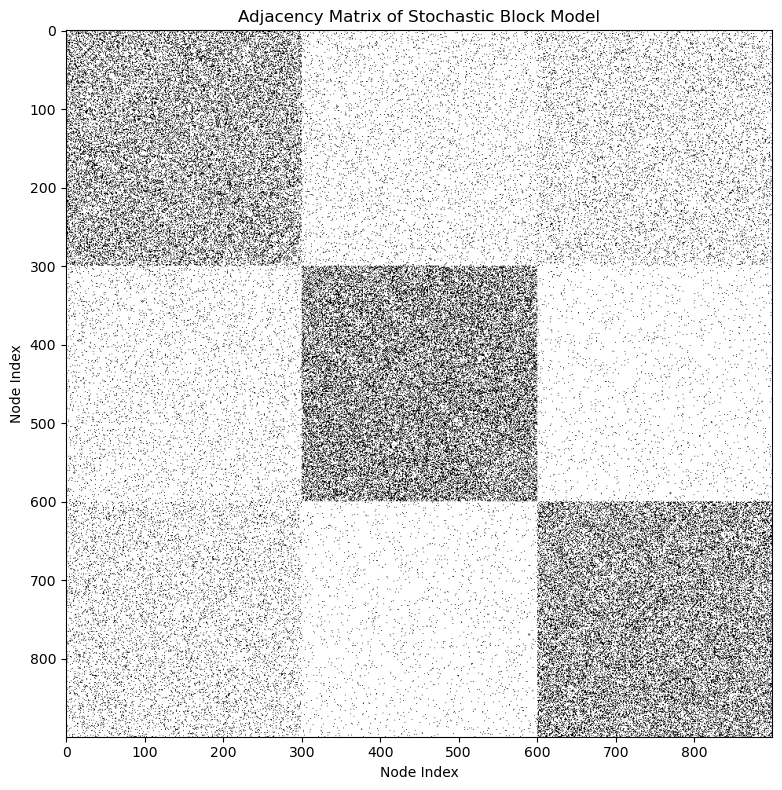

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import igraph

# Generate SBM
n, k = 900, 3

# Create block sizes (equal for simplicity)
block_sizes = [n // k] * k

# Create diverse pref matrix
pref_matrix = [
    [0.3, 0.05, 0.1],
    [0.05, 0.4, 0.02],
    [0.1, 0.02, 0.35]
]

# Generate SBM using igraph
g = igraph.Graph.SBM(n, pref_matrix, block_sizes)

# Convert to adjacency matrix for visualization
A = np.array(g.get_adjacency().data)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(A, cmap='binary')
plt.title("Adjacency Matrix of Stochastic Block Model")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.tight_layout()
plt.show()

## Characterizing network structures with the SBM

Stochastic Block Model is a flexible model that can be used to describe a wide range of network structures.

Let's start with communities where nodes within a community are more likely to be connected to each other than nodes in different communities. We can describe this using SBM by:

$$
P_{c,c'} = \begin{cases}
    p_{\text{in}} & \text{if } c = c' \\
    p_{\text{out}} & \text{if } c \neq c'
\end{cases}
$$

-  $p_{\text{in}}$ is the chance of a connection between nodes in the same community
- $p_{\text{out}}$ is the chance of a connection between nodes in different communities

Usually, we set $p_{\text{in}} > p_{\text{out}}$, because nodes in the same community tend to be more connected.

But, there's more SBM can do:

1. **Disassortative communities**: What if we flip things around and set $p_{\text{in}} < p_{\text{out}}$? Now we have communities where nodes prefer to connect with nodes from other communities. This is not in line with the communities we have focused on so far. Yet, it is still a valid model of community structure, and SBM allows for this generalization of community structure easily.

2. **Random networks**: If we make $p_{\text{in}} = p_{\text{out}}$, we get a completely random network where every node has an equal chance of connecting to any other node. This is what we call an Erdős-Rényi network.

In sum, SBM has been used as a playground for network scientists. We can use it to create many interesting network structures and study how they behave.

## Generating networks with SBM

It is easy to generate networks with SBM using igraph.
For example, the assortativity communities can be generated as follows.

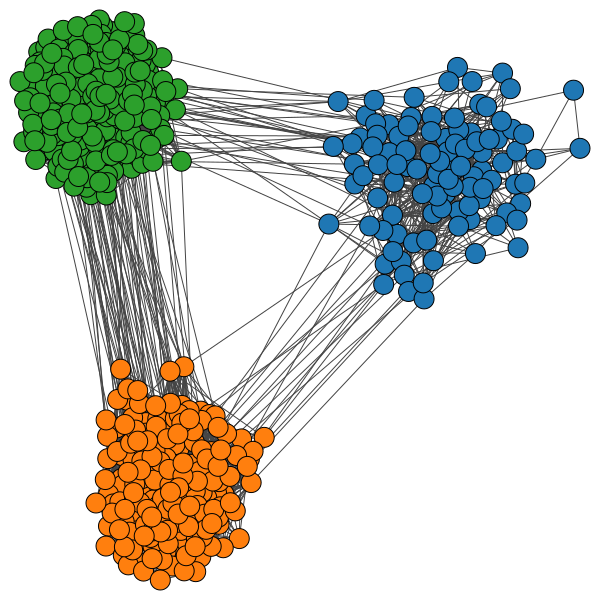

In [2]:
import igraph

p_in = 0.1
p_out = 0.001
block_sizes = [100, 200, 300]
n = sum(block_sizes)

pref_matrix = [
    [p_in, p_out, p_out],
    [p_out, p_in, p_out],
    [p_out, p_out, p_in]
]

g = igraph.Graph.SBM(n, pref_matrix, block_sizes)

# Plot the network
import seaborn as sns
palette = sns.color_palette()

community_colors = sum([[palette[i]] * block_sizes[i] for i in range(len(block_sizes))], [])
igraph.plot(g, vertex_color=community_colors)

- `pref_matrix` is the matrix of connection probabilities between communities. Its $(i,j)$th-element is the probability of a connection between nodes in community $i$ and $j$.


## Detecting communities with SBM

Imagine you're a detective trying to figure out how a network was created. You have a hunch about the community structure, and you want to know if it matches the network you see. That's exactly what we're going to do to find out communities!

Here's how we can describe the probability of seeing a particular network, given a community structure:

$$
P(\left\{A_{ij}\right\}_{ij}) = \prod_{i<j} P(A_{ij}=1|c_i, c_j)^{A_{ij}} (1-P(A_{ij}=1|c_i, c_j))^{1-A_{ij}}
$$

Let's break this down into simpler terms:

- First, $\left\{A_{ij}\right\}_{ij}$ is just a fancy way of saying "all the connections in our network". Think of it as a big table showing who's connected to whom.

- We use $\prod_{i < j}$ instead of $\prod_{i,j}$ because we're dealing with an undirected network. This means if Alice is friends with Bob, Bob is also friends with Alice. We only need to count this friendship once, not twice!

- The last part, $P(A_{ij}=1|c_i, c_j)^A_{ij}(1-P(A_{ij}=1|c_i, c_j))^{1-A_{ij}}$, might look scary, but it's actually quite clever. It's a shorthand way of saying "what's the chance of this connection existing or not existing?" If the connection exists ($A_{ij}=1$), we use the first part. If it doesn't ($A_{ij}=0$), we use the second part. It's a two-in-one formula.

Here's a neat trick we can use to make our lives easier. We can take the logarithm of both sides of our equation. This turns our big product (multiplication) into a simpler sum (addition).

$$
{\cal L}=\log P(\left\{A_{ij}\right\}_{ij}) = \sum_{i<j} A_{ij} \log P(A_{ij}=1|c_i, c_j) + (1-A_{ij}) \log (1-P(A_{ij}=1|c_i, c_j))
$$

We call this the **likelihood function**. It tells us how likely we are to see this network given our community guess. We can play around with different community assignments and edge probabilities to see which one gives us the highest likelihood.
To make this game easier, let's first figure out the best edge probabilities for a given community assignment.

Our likelihood function has a special shape - it is *a concave function* with respect to $p_{c,c'}$. This means that the likelihood function is a hill with only one peak when we look at it in terms of edge probability $p_{c,c'}$.

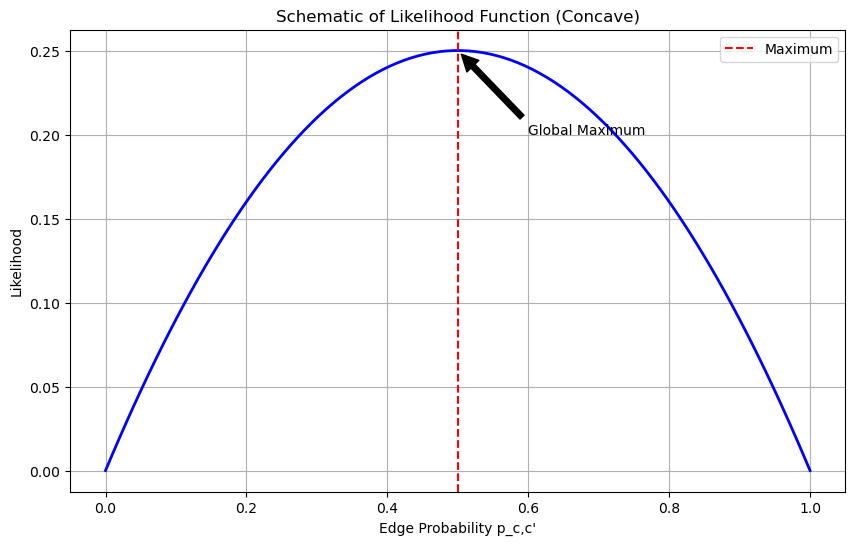

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def concave_function(x):
    return -(x - 0.5)**2 + 0.25

x = np.linspace(0, 1, 100)
y = concave_function(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.title('Schematic of Likelihood Function (Concave)')
plt.xlabel('Edge Probability p_c,c\'')
plt.ylabel('Likelihood')
plt.axvline(x=0.5, color='r', linestyle='--', label='Maximum')
plt.annotate('Global Maximum', xy=(0.5, 0.25), xytext=(0.6, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()
plt.grid(True)
plt.show()

So, what does this mean for us? The top of this hill (our maximum value) is flat, and there's only one flat spot on the whole hill. So if we can find a spot where the hill isn't sloping at all (that's what we mean by "zero gradient"), we've found the very top of the hill! 🏔️

In math terms, we take the derivative of our likelihood function with respect to $p_{c,c'}$ and set it to zero, i.e., $\partial {\cal L}  / \partial p_{cc'} = 0$. Here is what we get:


$$
\begin{aligned}
\frac{\partial {\cal L}}{\partial p_{c,c'}} &= 0 \\
\Rightarrow & \sum_{i<j} \left[A_{ij} \frac{1}{p_{c_i,c_j}} \delta(c_i,c)\delta(c_j,c') -(1-A_{ij}) \frac{1}{1-p_{c_i,c_j}}\delta(c_i,c')\delta(c_j,c') \right] = 0 \\
\Rightarrow &
\frac{m_{cc'}}{p_{c_i,c_j}} - \frac{\sum_{i < j} \delta(c_i,c)\delta(c_j,c') }{1-p_{c_i,c_j}} = 0 & \text{if } c \neq  c' \\
\Rightarrow & p_{c,c'} = \frac{m_{cc'}}{\sum_{i < j} \delta(c_i,c)\delta(c_j,c')}
\end{aligned}
$$

Let's break down these equations:

- $m_{cc'}$ is the number of edges between nodes in community $c$ and those in community $c'$.
- The derivative $\partial \log p_{cc} / \partial p_{cc}$ is just $1/p_{cc}$.

The denominator $\sum_{i < j} \delta(c_i,c)\delta(c_j,c')$ is the total number of pairs of nodes that belong to communities $c$ and $c'$. It is given by


$$
\sum_{i < j} \delta(c_i,c)\delta(c_j,c') =
\begin{cases}
n_cn_{c'} & \text{if } c \neq c' \\
\frac{n_c (n_c - 1)}{2} & \text{if } c = c'
\end{cases}
$$

Why do we have two different equations for $p_{c,c'}$? It's because we are counting each pair of nodes only by once. It is easy to verify when looking at the adjacency matrix:

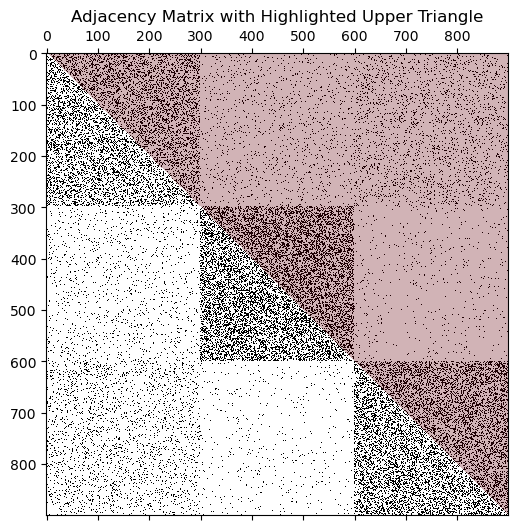

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import igraph

# Generate SBM
n, k = 900, 3

# Create block sizes (equal for simplicity)
block_sizes = [n // k] * k

# Create diverse pref matrix
pref_matrix = [
    [0.3, 0.05, 0.1],
    [0.05, 0.4, 0.02],
    [0.1, 0.02, 0.35]
]

# Generate SBM using igraph
g = igraph.Graph.SBM(n, pref_matrix, block_sizes)

# Convert to adjacency matrix for visualization
A = np.array(g.get_adjacency().data)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the adjacency matrix
ax.matshow(A, cmap='binary')
mask = np.triu(np.ones_like(A, dtype=bool), k=1)

# Highlight the upper triangle with yellow overlay
ax.matshow(np.ma.masked_array(np.ones_like(A), ~mask), cmap='Reds_r', alpha=0.3)

# Add a title
plt.title("Adjacency Matrix with Highlighted Upper Triangle")

plt.show()

The upper triangle of the adjacency matrix represents $i < j$ over which we take the sum.
When $c=c'$ (the diagonal block), we count only the upper half of the block, resulting in $\frac{n_c (n_c - 1)}{2}$. When $c \neq c'$ (different communities), we count all connections between them, resulting in $n_cn_{c'}$.

We have now obtaind the likelihood function based only on the community assignment. Maximizing ${\cal L}$ with respect to the community assignment gives us the most likely community assignment for the network.

```{footbibliography}
```